In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Original class counts: {'Vehicles': 5587}
Dataset balancing completed.

Extracting features using VGG16...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Feature matrix shape: (5587, 25088)


/tmp/ipython-input-868610368.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))


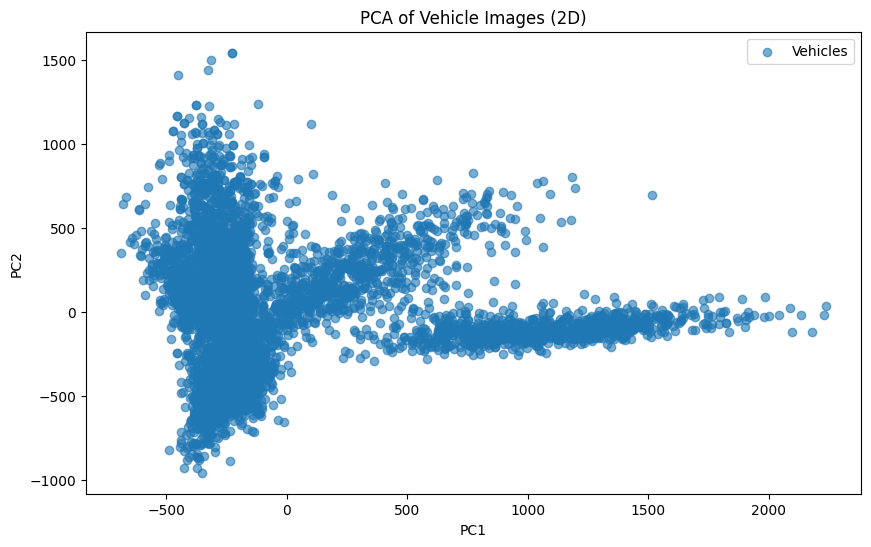

Class counts after balancing: {'Vehicles': 5587}


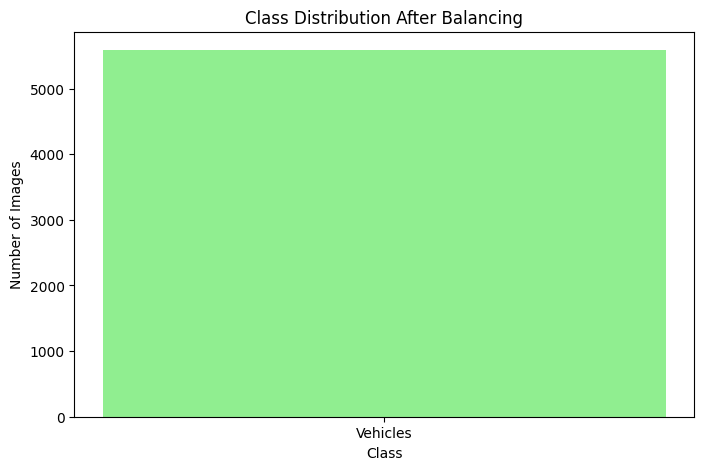

Part 6 completed successfully!


In [28]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.decomposition import PCA

# ================================
# Paths
# ================================
input_dir = '/content/drive/MyDrive/Img Dataset'
balanced_dir = '/content/drive/MyDrive/Img Dataset Balanced'
os.makedirs(balanced_dir, exist_ok=True)

# Allowed image extensions
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png')

# ================================
# Helper function to get all image files recursively
# ================================
def get_image_files(folder):
    image_files = []
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(IMG_EXTENSIONS):
                image_files.append(os.path.join(root, f))
    return image_files

# ================================
# Step 1: Balance dataset using augmentation
# ================================
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Collect classes
classes = [cls for cls in os.listdir(input_dir) if not cls.startswith('.')]
class_counts = {}
for cls in classes:
    class_path = os.path.join(input_dir, cls)
    image_files = get_image_files(class_path)
    class_counts[cls] = len(image_files)

max_count = max(class_counts.values())
print("Original class counts:", class_counts)

for cls in classes:
    class_path = os.path.join(input_dir, cls)
    save_class_path = os.path.join(balanced_dir, cls)
    os.makedirs(save_class_path, exist_ok=True)

    imgs = get_image_files(class_path)
    if len(imgs) == 0:
        print(f"No images found for class {cls}, skipping...")
        continue

    # Copy images to balanced folder
    for img_path in imgs:
        img_name = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(save_class_path, img_name))

    # Generate augmented images if needed
    n_needed = max_count - len(imgs)
    i = 0
    while i < n_needed:
        for img_path in imgs:
            if i >= n_needed:
                break
            try:
                img = load_img(img_path, target_size=(224,224))
            except Exception as e:
                print(f"Skipping corrupted image: {img_path}")
                continue
            x = img_to_array(img).reshape((1,) + img_to_array(img).shape)
            for batch in datagen.flow(x, batch_size=1, save_to_dir=save_class_path, save_prefix='aug', save_format='jpg'):
                i += 1
                break

print("Dataset balancing completed.\n")

# ================================
# Step 2: Feature extraction using VGG16
# ================================
print("Extracting features using VGG16...")
model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

all_features = []
all_labels = []

for cls in classes:
    class_path = os.path.join(balanced_dir, cls)
    imgs = get_image_files(class_path)
    if len(imgs) == 0:
        continue

    for img_path in imgs:
        try:
            img = load_img(img_path, target_size=(224,224))
        except Exception:
            continue
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array, verbose=0)
        all_features.append(features.flatten())
        all_labels.append(cls)

all_features = np.array(all_features)
if all_features.shape[0] == 0:
    raise ValueError("No valid images found for feature extraction!")

print("Feature matrix shape:", all_features.shape)

# ================================
# Step 3: PCA 2D visualization
# ================================
pca = PCA(n_components=2)
features_2d = pca.fit_transform(all_features)

plt.figure(figsize=(10,6))
unique_classes = list(set(all_labels))
colors = plt.cm.get_cmap('tab10', len(unique_classes))

for i, cls in enumerate(unique_classes):
    idxs = [j for j, x in enumerate(all_labels) if x == cls]
    plt.scatter(features_2d[idxs,0], features_2d[idxs,1], label=cls, alpha=0.6, color=colors(i))

plt.title("PCA of Vehicle Images (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# ================================
# Step 4: Class distribution after balancing
# ================================
new_class_counts = {cls: len(get_image_files(os.path.join(balanced_dir, cls))) for cls in classes}
print("Class counts after balancing:", new_class_counts)

plt.figure(figsize=(8,5))
plt.bar(new_class_counts.keys(), new_class_counts.values(), color='lightgreen')
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

print("Part 6 completed successfully!")
